In [5]:
import warnings
import logging


warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [6]:
from utils import make_environments
from utils import pearl_utils
from configs import futures_defaults as defaults
from utils.reward_functions import log_reward_function,cumulative_reward_function,sharpe_reward_function
from utils. utils import make_hidden_dims
import optuna
from optuna.samplers import TPESampler
from neuralforecast.core import NeuralForecast
from Pearl.pearl.utils.instantiations.environments.gym_environment import GymEnvironment
from Pearl.pearl.utils.functional_utils.train_and_eval.online_learning import \
    online_learning
import datetime

In [7]:
# model=NeuralForecast.load('MultiHeadForecastingModel/')

Seed set to 13
Seed set to 16
Seed set to 11


['data_futures/coinbase-DOGEUSD_Futures-1h.pkl']


100%|██████████| 78/78 [00:00<00:00, 12862.42it/s]
1it [00:00,  9.42it/s]


,low,high,open,close,volume,symbol,y,feature_hour_of_day,feature_day_of_week,feature_day_of_month,feature_day_of_year,feature_BBANDS_BB_UPPER,feature_BBANDS_BB_MIDDLE,feature_BBANDS_BB_LOWER,feature_MACD_MACD,feature_MACD_SIGNAL,feature_14_period_RSI,feature_14_period_STOCH_%K,ds,unique_id
date_close,,,,,,,,,,,,,,,,,,,,
2024-05-15 14:00:32,0.15106,0.15283,0.15135,0.15268,12076044,DOGEUSD_Futures,0.15268,0.108696,-0.166667,-0.033333,-0.130137,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,2024-05-15 14:00:32,29
2024-05-15 13:00:48,0.15096,0.15374,0.15198,0.15135,13639206,DOGEUSD_Futures,0.15135,0.065217,-0.166667,-0.033333,-0.130137,0.0,0.0,0.0,-0.000030,-0.000017,0.000000,0.0,2024-05-15 13:00:48,29
2024-05-15 12:01:04,0.14797,0.15447,0.14936,0.15199,18400456,DOGEUSD_Futures,0.15199,0.021739,-0.166667,-0.033333,-0.130137,0.0,0.0,0.0,-0.000018,-0.000017,34.133333,0.0,2024-05-15 12:01:04,29
2024-05-15 10:59:12,0.14814,0.15093,0.15016,0.14934,14101743,DOGEUSD_Futures,0.14934,-0.065217,-0.166667,-0.033333,-0.130137,0.0,0.0,0.0,-0.000108,-0.000048,13.533957,0.0,2024-05-15 10:59:12,29
2024-05-15 09:59:28,0.14894,0.15095,0.15034,0.15018,14066598,DOGEUSD_Futures,0.15018,-0.108696,-0.166667,-0.033333,-0.130137,0.0,0.0,0.0,-0.000121,-0.000070,28.304187,0.0,2024-05-15 09:59:28,29


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Index(['low', 'high', 'open', 'close', 'volume', 'symbol', 'y',
       'feature_hour_of_day', 'feature_day_of_week', 'feature_day_of_month',
       'feature_day_of_year', 'feature_BBANDS_BB_UPPER',
       'feature_BBANDS_BB_MIDDLE', 'feature_BBANDS_BB_LOWER',
       'feature_MACD_MACD', 'feature_MACD_SIGNAL', 'feature_14_period_RSI',
       'feature_14_period_STOCH_%K', 'ds', 'unique_id'],
      dtype='object')


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2024-10-16 13:00:00 2024-11-15 13:00:00


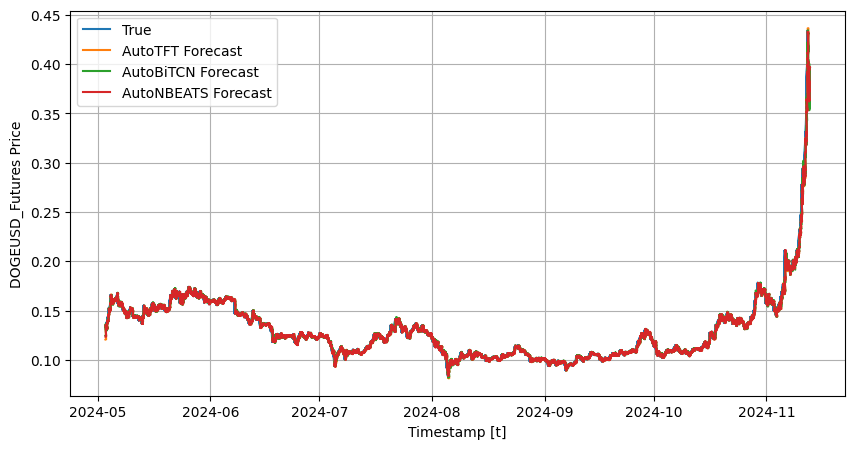

In [8]:
reward_functions=[log_reward_function,cumulative_reward_function,sharpe_reward_function]
train_env,test_env=make_environments.make_envs(reward_function=log_reward_function)


In [9]:
sp=train_env.positions
train_env.action_space.n
train_env.name

'DOGEUSD_Futures_train'

In [10]:
make_hidden_dims(n_layers=3, n_units=64)

[64, 64, 64]

In [11]:
agent=pearl_utils.create_ddqn_model(

        observation_space_dim=train_env.observation_space.shape[0], 
        action_space_dim=train_env.action_space.n,
        hidden_dims=[64,64, 64], 
        training_rounds=20,
        learning_rate = 0.001,
        discount_factor = 0.99,
        batch_size = 128,
        target_update_freq = 10,
        soft_update_tau = 0.75,  # a value of 1 indicates no soft updates
        is_conservative = False,
        conservative_alpha = False,
        replay_buffer_size = 10_000,
        lstm=False)

In [12]:
test_env.observation_space.shape,train_env.action_space.n

((30,), 3)

In [13]:
env=GymEnvironment(train_env)

obs,action_space=env.reset()
agent.reset(   obs, action_space)

In [14]:
# done = False
# while not done:
#     action = agent.act(exploit=False)
#     action_result = env.step(action)
    
#     agent.observe(action_result)
#     loss=agent.learn()

#     done = action_result.done

In [15]:
info = online_learning(
        agent=agent,
        env=env,
        # number_of_episodes=10,
        number_of_steps=168,
        print_every_x_episodes=2,   # print returns after every 10 episdoes
        print_every_x_steps=1,   # print returns after every 10 episdoes
        learn_every_k_steps=20,   # print returns after every 10 episdoes
        learn_after_episode=False,
        record_period=169,   # instead of updating after every environment interaction, Q networks are updates at the end of each episode
        seed=0
    )

  0%|          | 0/168 [00:00<?, ?it/s]

In [16]:
33//1

33

In [17]:


def objective_function(trial):
 
    reward_id=trial.suggest_categorical('reward_function', [0,1,2])
    algo=trial.suggest_categorical('algorithm', ['dqn','ddqn'])    

    # reward_id=0
    
    reward_func=reward_functions[reward_id]
    train_env.reward_func=reward_func
    test_env.reward_func=reward_func
    
    observation_space_dim=train_env.observation_space.shape[0]
    action_space_dim=len(train_env.positions)
    n_layers=trial.suggest_int('n_layers', 1, 3)
    n_units=trial.suggest_categorical('n_units', [64,128,256,512])
    
    hidden_dims=make_hidden_dims(n_layers= n_layers, n_units=n_units)
    
    search_space={
                'observation_space_dim': observation_space_dim,
                'action_space_dim': action_space_dim,
                'hidden_dims': hidden_dims,
                'training_rounds': trial.suggest_int('training_rounds', 5, 30),
                'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-4),
                'discount_factor': trial.suggest_float('discount_factor', 0.8, 0.99), # gamma (greediness)
                'batch_size': trial.suggest_categorical('batch_size', [64, 128]),
                'target_update_freq': trial.suggest_categorical('target_update_freq', [1, 5, 10, 24]),
                'soft_update_tau': trial.suggest_float('soft_update_tau', 0.1, .99), 
                'is_conservative': trial.suggest_categorical('is_conservative', [True, False]),
                'lstm': trial.suggest_categorical('lstm', [True, False]),
                'conservative_alpha': trial.suggest_float('conservative_alpha', 0.5, 1.0),
                }

    learning_space={'learn_after_episode':trial.suggest_categorical('learn_after_episode', [True, False]),
                    'learning_steps':trial.suggest_int('learning_steps', 10, 89),
                    'n_epochs':trial.suggest_categorical('n_epochs',[100,500]),
                    }
    #
    # print('n_epochs',n_epochs)
    if algo=='dqn':
        agent=pearl_utils.create_dqn_model(**search_space)
    elif algo=='ddqn':
        agent=pearl_utils.create_ddqn_model(**search_space)

        
    agent=pearl_utils.train_pearl_model(agent,train_env,**learning_space)
    profit,n_trades=pearl_utils.test_pearl_model(agent,test_env)

    print('profit',profit,'n_trades',n_trades)
    return profit ,n_trades

In [18]:
model_name=defaults.model_name
model_name

'DOGEUSDFutures'

In [19]:
today=datetime.datetime.now().strftime('%Y-%m-%d')
study = optuna.create_study(study_name=f"pearl-{model_name}-hp-search",
                            directions=["maximize", "maximize"],
                            storage="sqlite:///pearl_hyper_parameters.sqlite3",
                            load_if_exists=True,
                            sampler=TPESampler()
                            )


[I 2024-11-15 12:53:42,442] Using an existing study with name 'pearl-DOGEUSDFutures-hp-search' instead of creating a new one.


In [ ]:
study.optimize(objective_function, n_trials=30)


  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [36:56<?, ?it/s]
[I 2024-11-15 13:32:35,357] Trial 3 finished with values: [799.6119499605857, 0.99] and parameters: {'reward_function': 0, 'algorithm': 'ddqn', 'n_layers': 1, 'n_units': 512, 'training_rounds': 14, 'learning_rate': 1.3960573597922878e-05, 'discount_factor': 0.8635381182419978, 'batch_size': 64, 'target_update_freq': 1, 'soft_update_tau': 0.8916753769162811, 'is_conservative': True, 'lstm': True, 'conservative_alpha': 0.9465702386006113, 'learn_after_episode': False, 'learning_steps': 51, 'n_epochs': 500}.


profit 799.6119499605857 n_trades 0.99


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:22<?, ?it/s]
[I 2024-11-15 13:32:59,688] Trial 4 finished with values: [851.7813116361198, 46.19] and parameters: {'reward_function': 0, 'algorithm': 'dqn', 'n_layers': 2, 'n_units': 64, 'training_rounds': 15, 'learning_rate': 4.054520562046531e-05, 'discount_factor': 0.9427272142130948, 'batch_size': 128, 'target_update_freq': 1, 'soft_update_tau': 0.842841975344867, 'is_conservative': False, 'lstm': False, 'conservative_alpha': 0.755978558002309, 'learn_after_episode': True, 'learning_steps': 17, 'n_epochs': 500}.


profit 851.7813116361198 n_trades 46.19


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:40<?, ?it/s]
[I 2024-11-15 13:33:42,362] Trial 5 finished with values: [796.6223607647315, 99.83] and parameters: {'reward_function': 0, 'algorithm': 'dqn', 'n_layers': 1, 'n_units': 128, 'training_rounds': 17, 'learning_rate': 8.922585384293464e-05, 'discount_factor': 0.8241519742917153, 'batch_size': 128, 'target_update_freq': 24, 'soft_update_tau': 0.7761716908166678, 'is_conservative': False, 'lstm': False, 'conservative_alpha': 0.7218626114022653, 'learn_after_episode': False, 'learning_steps': 45, 'n_epochs': 500}.


profit 796.6223607647315 n_trades 99.83


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/16800 [00:00<?, ?it/s]

  0%|          | 0/100 [09:04<?, ?it/s]
[I 2024-11-15 13:44:47,353] Trial 6 finished with values: [999.9369970997099, 0.63] and parameters: {'reward_function': 0, 'algorithm': 'ddqn', 'n_layers': 3, 'n_units': 512, 'training_rounds': 29, 'learning_rate': 3.639789123108986e-05, 'discount_factor': 0.9547956051292215, 'batch_size': 64, 'target_update_freq': 10, 'soft_update_tau': 0.33860447402144644, 'is_conservative': False, 'lstm': True, 'conservative_alpha': 0.7902357321792972, 'learn_after_episode': False, 'learning_steps': 80, 'n_epochs': 100}.


profit 999.9369970997099 n_trades 0.63


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

In [ ]:
# print(f"Best value: {study.best_value} (params: {study.best_params})")
best_trials=study.best_trials
best_trials

In [ ]:
best_trials=study.best_trials
best_trail=best_trials[3]
best_params=best_trail.params
reward_func=reward_functions[best_params.pop('reward_function')]
train_env.reward_func=reward_func
test_env.reward_func=reward_func

In [ ]:
algo=best_params.pop('algorithm')

learning_params={'learn_after_episode':best_params.pop('learn_after_episode'),
                    'learning_steps':best_params.pop('learning_steps'),
                    'n_epochs':best_params.pop('n_epochs'),
                    }
best_params['hidden_dims']=make_hidden_dims(n_layers=best_params.pop('n_layers'),n_units=best_params.pop('n_units'))
best_params['lstm']=best_params.pop('use_lstm')
if algo=='dqn':
    agent=pearl_utils.create_dqn_model(**best_params)
elif algo=='ddqn':
    agent=pearl_utils.create_ddqn_model(**best_params)

best_params,learning_params

In [ ]:


agent=pearl_utils.train_pearl_model(agent,train_env,**learning_params)

profit,n_trades=pearl_utils.test_pearl_model(agent,test_env)

agent=pearl_utils.train_pearl_model(agent,test_env,**learning_params)

In [ ]:
import pickle
import numpy as np

if -1 in [np.sign(p) for p in test_env.positions]:
    market_type='Futures'
else:
    market_type='Spot'
agent_path=f'Agent/{today}_pearl_{defaults.model_name}_model.pkl'

pickle.dump(agent,open(agent_path,'wb'))

